In [2]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

INPUT_CSV = "synthetic_patients.csv"
OUT_DIR = "clients_data"  # will create one csv per superpopulation
SUPERPOP_COL = "superpopulation"

## Data prep (split by ancestry clients, assuming data was collected by a separate client)

In [3]:
df = pd.read_csv(INPUT_CSV)

os.makedirs(OUT_DIR, exist_ok=True)
for sp, g in df.groupby(SUPERPOP_COL):
    out = os.path.join(OUT_DIR, f"client_{sp}.csv")
    g.to_csv(out, index=False)
    print("wrote", out, "rows", len(g))

wrote clients_data/client_AFR.csv rows 3000
wrote clients_data/client_AMR.csv rows 3000
wrote clients_data/client_EAS.csv rows 3000
wrote clients_data/client_EUR.csv rows 3000
wrote clients_data/client_SAS.csv rows 3000


metrics: output_nvflare_kmeans/server/nvflare_workspace_fed_kmeans/kmeans_metrics.csv
centers: output_nvflare_kmeans/server/nvflare_workspace_fed_kmeans/final_centers.npy shape (5, 423)
Running k=5...
2026-01-09 22:11:46,347 - INFO - Initializing ScatterAndGather workflow for Federated Averaging.
2026-01-09 22:11:46,348 - INFO - Beginning ScatterAndGather training phase.
2026-01-09 22:11:46,349 - INFO - Round 0 started.
2026-01-09 22:11:50,568 - INFO - Contribution from AMR ACCEPTED by the aggregator at round 0.
2026-01-09 22:11:50,667 - INFO - Contribution from EUR ACCEPTED by the aggregator at round 0.
2026-01-09 22:11:50,761 - INFO - Contribution from EAS ACCEPTED by the aggregator at round 0.
2026-01-09 22:11:50,813 - INFO - Contribution from SAS ACCEPTED by the aggregator at round 0.
2026-01-09 22:11:51,556 - INFO - Contribution from AFR ACCEPTED by the aggregator at round 0.
2026-01-09 22:11:51,733 - INFO - Start aggregation.
round 00 inertia 22783.40 moved 48.1214 counts [657, 2

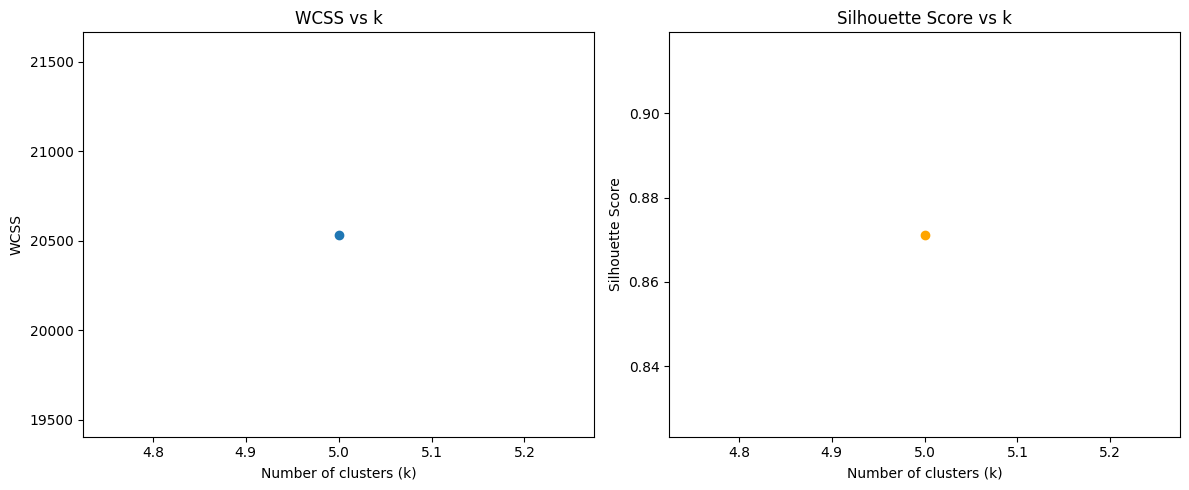

In [15]:
from sklearn.metrics import silhouette_score

ws = []
sils = []
for i in range(5, 6):
    metrics_paths = glob.glob("output_nvflare_kmeans/**/kmeans_metrics.csv", recursive=True)
    centers_paths = glob.glob("output_nvflare_kmeans/**/final_centers.npy", recursive=True)

    metrics_path = sorted(metrics_paths)[-1]
    centers_path = sorted(centers_paths)[-1]

    m = pd.read_csv(metrics_path)
    centers = np.load(centers_path)

    print("metrics:", metrics_path)
    print("centers:", centers_path, "shape", centers.shape)

    # 2) load pooled data
    df = pd.read_csv(INPUT_CSV)
    drop_cols = {"patient_id", "superpopulation", "n_variants_carried", "primary_gene", "primary_condition", "primary_subtype", "onset_type","base_impact","allelic_ratio","ancestral_modifier","modifier_type","consequence_modifier","interaction_score","predicted_progression", "all_genes","all_subtypes"}
    feat_cols = [c for c in df.columns if c not in drop_cols]
    X = df[feat_cols].to_numpy(dtype=np.float32)

    Xs = X
    Cs = centers
    
    d2 = ((Xs[:, None, :] - Cs[None, :, :]) ** 2).sum(axis=2)
    labels = d2.argmin(axis=1)
    print(f"Running k={i}...")
    !python "main.py" --k {i} --num_rounds 10 --seed 2026 --workspace output_nvflare_kmeans
    wcss = 0.0
    for k in range(Cs.shape[0]):
        cluster_points = Xs[labels == k]
        # if cluster_points.shape[0] > 0:
            # sum of squared distances to the center
        wcss += ((cluster_points - Cs[k]) ** 2).sum()
    ws.append((i, wcss))
    n = Xs.shape[0]
    try:
        if n > 20000:
            rng = np.random.default_rng(0)
            idx = rng.choice(n, size=20000, replace=False)
            sil = silhouette_score(Xs[idx], labels[idx], metric="euclidean")
        else:
            sil = silhouette_score(Xs, labels, metric="euclidean")
    except:
        sil = -1.0

    print("silhouette:", sil)
    sils.append((i, sil))
    # print("WCSS (Within-Cluster Sum of Squares):", wcss)
    
print("k and sil vs WCSS:")
ws = np.array(ws)
sils = np.array(sils)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ws[:, 0], ws[:, 1], marker='o')
plt.title("WCSS vs k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.subplot(1, 2, 2)
plt.plot(sils[:, 0], sils[:, 1], marker='o', color='orange')
plt.title("Silhouette Score vs k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()


## Compute silhouette and basic cluster stats (centralized evaluation)

In [16]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# 1) load the server outputs
metrics_paths = glob.glob("output_nvflare_kmeans/**/kmeans_metrics.csv", recursive=True)
centers_paths = glob.glob("output_nvflare_kmeans/**/final_centers.npy", recursive=True)

metrics_path = sorted(metrics_paths)[-1]
centers_path = sorted(centers_paths)[-1]

m = pd.read_csv(metrics_path)
centers = np.load(centers_path)

print("metrics:", metrics_path)
print("centers:", centers_path, "shape", centers.shape)

# 2) load pooled data
df = pd.read_csv(INPUT_CSV)
drop_cols = {"patient_id", "superpopulation", "n_variants_carried", "primary_gene", "primary_condition", "primary_subtype", "onset_type","base_impact","allelic_ratio","ancestral_modifier","modifier_type","consequence_modifier","interaction_score","predicted_progression", "all_genes","all_subtypes"}
feat_cols = [c for c in df.columns if c not in drop_cols]
X = df[feat_cols].to_numpy(dtype=np.float32)

# optional: scaling (only do this if you also scaled during training)
# scaler = StandardScaler(with_mean=True, with_std=True)
# Xs = scaler.fit_transform(X)
# Cs = scaler.transform(centers)
Xs = X
Cs = centers

# 3) assign clusters with your final centers
d2 = ((Xs[:, None, :] - Cs[None, :, :]) ** 2).sum(axis=2)
labels = d2.argmin(axis=1)

# 4) silhouette (sample if big)
n = Xs.shape[0]
if n > 20000:
    rng = np.random.default_rng(0)
    idx = rng.choice(n, size=20000, replace=False)
    sil = silhouette_score(Xs[idx], labels[idx], metric="euclidean")
else:
    sil = silhouette_score(Xs, labels, metric="euclidean")

print("silhouette:", sil)

# 5) cluster sizes
sizes = pd.Series(labels).value_counts().sort_index()
print("cluster sizes:\n", sizes)

# 6) compute WCSS (Within-Cluster Sum of Squares)



metrics: output_nvflare_kmeans/server/nvflare_workspace_fed_kmeans/kmeans_metrics.csv
centers: output_nvflare_kmeans/server/nvflare_workspace_fed_kmeans/final_centers.npy shape (5, 423)
silhouette: 0.6559000611305237
cluster sizes:
 0     287
1    3287
2    1999
3    8582
4     845
Name: count, dtype: int64


## Bootstrap stability for clustering
- answers: do we get the same clustering if we resample patients and rerun k means from the same initialization?

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def bootstrap_stability(X, base_labels, k, init_centers, B=50, seed=0):
    rng = np.random.default_rng(seed)
    n = X.shape[0]
    scores = []
    for b in range(B):
        idx = rng.integers(0, n, size=n)  # bootstrap sample indices
        Xb = X[idx]

        km = KMeans(
            n_clusters=k,
            init=init_centers,
            n_init=1,
            max_iter=100,
            random_state=seed + b,
        ).fit(Xb)

        # predict labels on full X using bootstrapped centers
        Cb = km.cluster_centers_.astype(np.float32)
        d2 = ((X[:, None, :] - Cb[None, :, :]) ** 2).sum(axis=2)
        pred = d2.argmin(axis=1)

        scores.append(adjusted_rand_score(base_labels, pred))
    return np.array(scores)

k = centers.shape[0]
st = bootstrap_stability(Xs, labels, k=k, init_centers=Cs, B=50, seed=7)
print("ARI mean", st.mean(), "std", st.std(), "min", st.min(), "max", st.max())

ARI mean 1.0 std 0.0 min 1.0 max 1.0


# Visualization

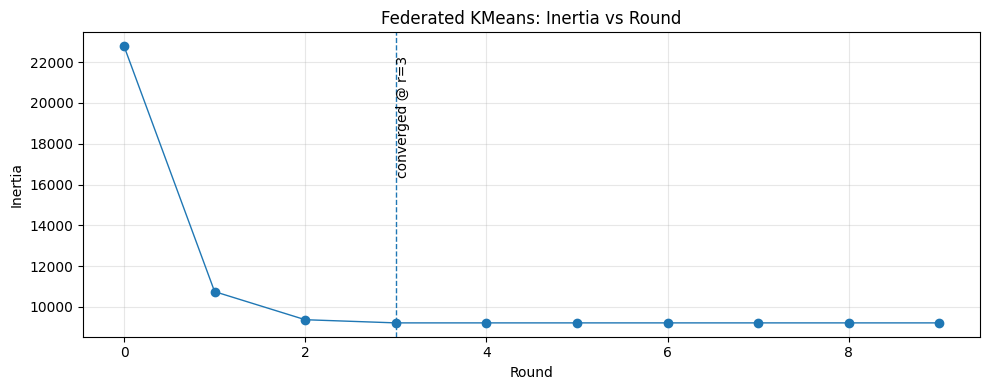

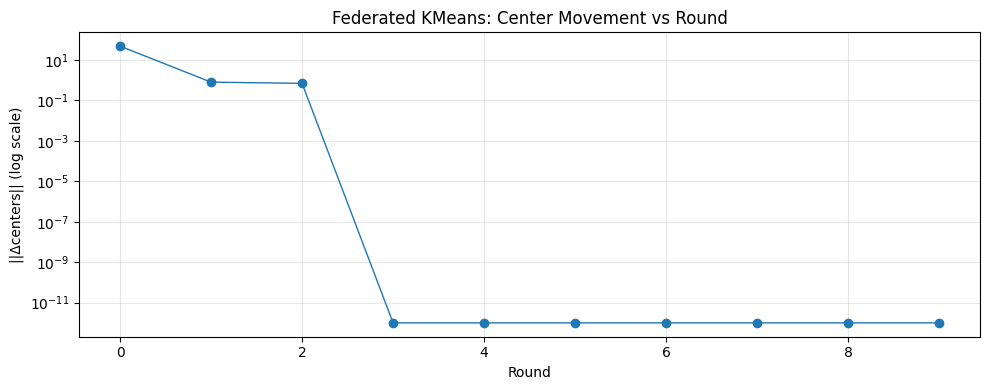

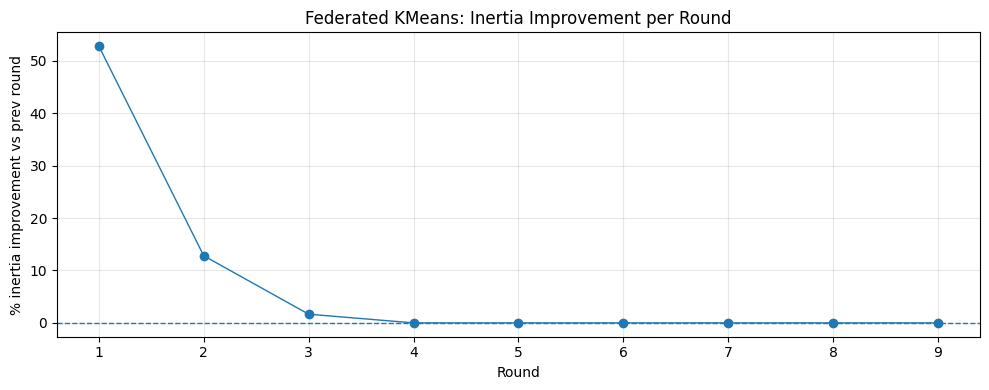

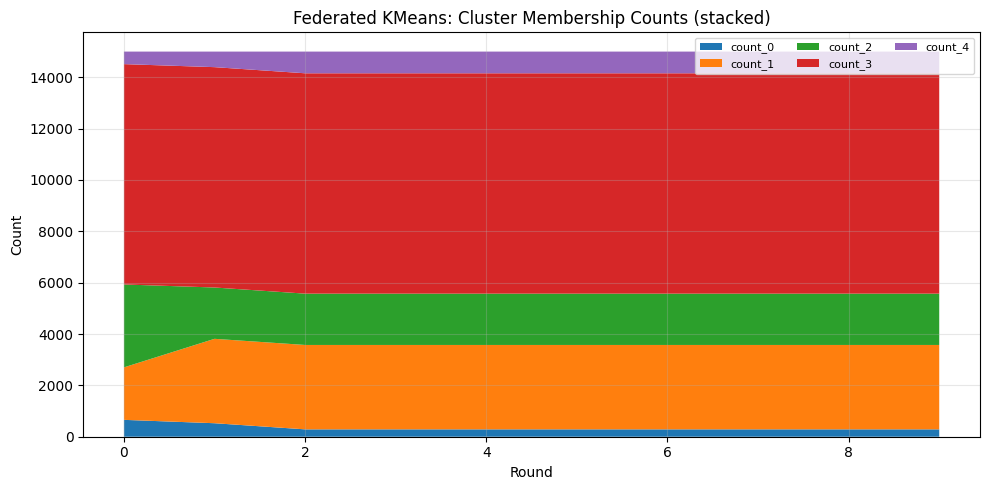

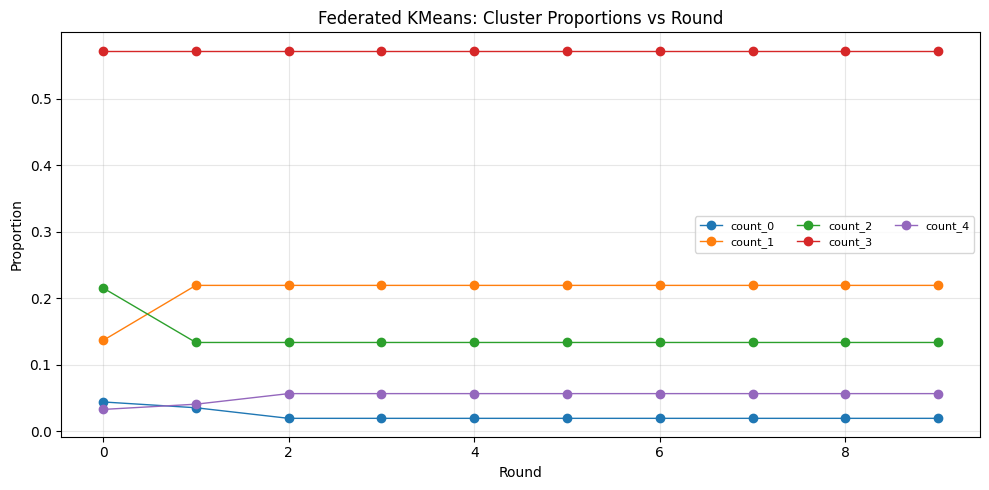

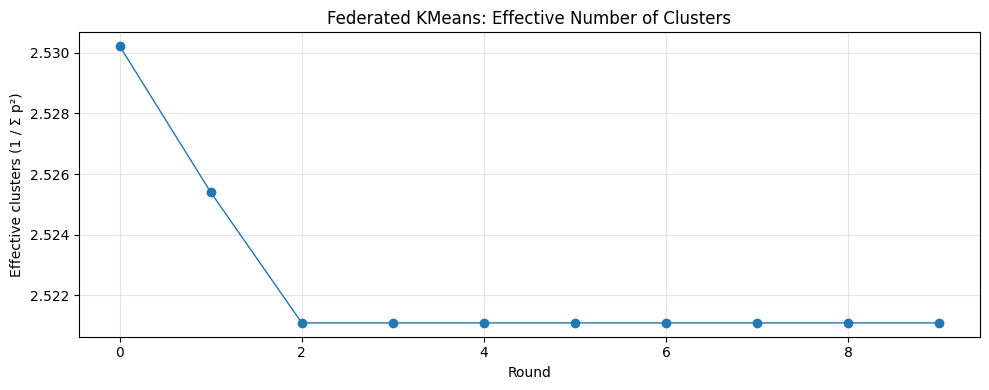

Converged round: 3
Final inertia: 9219.8017578125
Final counts: {'count_0': 287, 'count_1': 3287, 'count_2': 1999, 'count_3': 8582, 'count_4': 845}
Dead clusters: []
Tiny clusters: []


In [20]:
csv_path = glob.glob("output_nvflare_kmeans/**/kmeans_metrics.csv", recursive=True)
m = pd.read_csv(csv_path[-1]).sort_values("round").reset_index(drop=True)

rounds = m["round"].to_numpy()
inertia = m["inertia"].to_numpy()
moved = m["moved"].to_numpy()

count_cols = [c for c in m.columns if c.startswith("count_")]
counts = m[count_cols].to_numpy()
total = counts.sum(axis=1)
props = counts / total[:, None]

# find convergence round: first round where moved == 0 and stays 0
conv_r = None
for i in range(len(rounds)):
    if moved[i] == 0 and np.all(moved[i:] == 0):
        conv_r = int(rounds[i])
        break

# 1) Inertia with improvement annotations
plt.figure(figsize=(10,4))
plt.plot(rounds, inertia, marker="o", linewidth=1)
plt.grid(True, alpha=0.3)
plt.xlabel("Round")
plt.ylabel("Inertia")
plt.title("Federated KMeans: Inertia vs Round")
if conv_r is not None:
    plt.axvline(conv_r, linestyle="--", linewidth=1)
    plt.text(conv_r, inertia.max()*0.98, f"converged @ r={conv_r}", rotation=90, va="top")
plt.tight_layout()
plt.show()

# 2) Movement (log scale helps when it quickly goes to 0)
eps = 1e-12
plt.figure(figsize=(10,4))
plt.plot(rounds, moved + eps, marker="o", linewidth=1)
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.xlabel("Round")
plt.ylabel("||Δcenters|| (log scale)")
plt.title("Federated KMeans: Center Movement vs Round")
plt.tight_layout()
plt.show()

# 3) Percent improvement in inertia per round
din = np.r_[np.nan, np.diff(inertia)]
pct = np.r_[np.nan, 100.0 * (inertia[:-1] - inertia[1:]) / np.maximum(inertia[:-1], 1e-12)]
plt.figure(figsize=(10,4))
plt.plot(rounds, pct, marker="o", linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1)
plt.grid(True, alpha=0.3)
plt.xlabel("Round")
plt.ylabel("% inertia improvement vs prev round")
plt.title("Federated KMeans: Inertia Improvement per Round")
plt.tight_layout()
plt.show()

# 4) Cluster counts as stacked area (shows dominance + dead clusters)
plt.figure(figsize=(10,5))
plt.stackplot(rounds, counts.T, labels=count_cols)
plt.grid(True, alpha=0.3)
plt.xlabel("Round")
plt.ylabel("Count")
plt.title("Federated KMeans: Cluster Membership Counts (stacked)")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

# 5) Cluster proportions (lines)
plt.figure(figsize=(10,5))
for j, c in enumerate(count_cols):
    plt.plot(rounds, props[:, j], marker="o", linewidth=1, label=c)
plt.grid(True, alpha=0.3)
plt.xlabel("Round")
plt.ylabel("Proportion")
plt.title("Federated KMeans: Cluster Proportions vs Round")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

# 6) Effective number of clusters (1 / sum p^2), a nice “diversity” metric
eff_k = 1.0 / np.sum(props**2, axis=1)
plt.figure(figsize=(10,4))
plt.plot(rounds, eff_k, marker="o", linewidth=1)
plt.grid(True, alpha=0.3)
plt.xlabel("Round")
plt.ylabel("Effective clusters (1 / Σ p²)")
plt.title("Federated KMeans: Effective Number of Clusters")
plt.tight_layout()
plt.show()

# summary
final_counts = dict(zip(count_cols, counts[-1].tolist()))
dead = [c for c, v in final_counts.items() if v == 0]
tiny = [c for c, v in final_counts.items() if 0 < v <= 50]

print("Converged round:", conv_r)
print("Final inertia:", float(inertia[-1]))
print("Final counts:", final_counts)
print("Dead clusters:", dead)
print("Tiny clusters:", tiny)

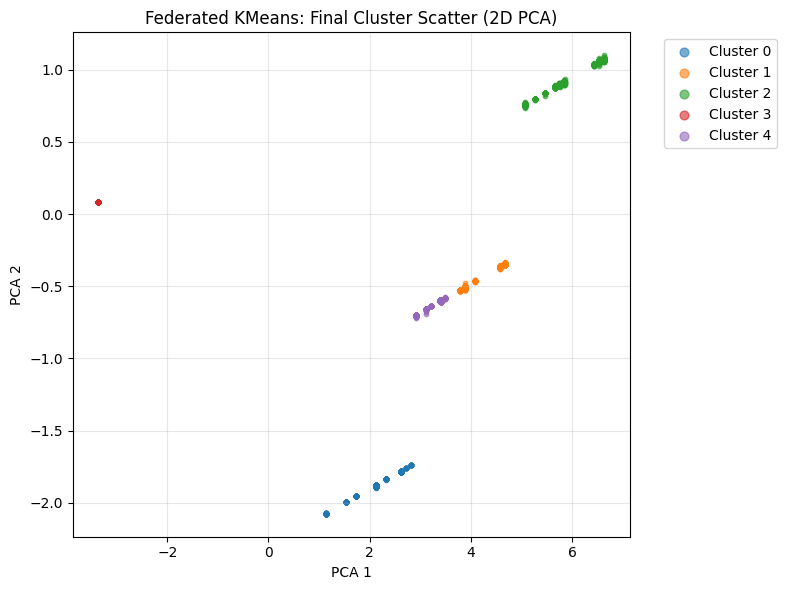

In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

centers_paths = glob.glob("output_nvflare_kmeans/**/final_centers.npy", recursive=True)
centers = np.load(sorted(centers_paths)[-1])  # last run
d2 = ((Xs[:, None, :] - centers[None, :, :]) ** 2).sum(axis=2)
labels = d2.argmin(axis=1)

# --- 1) Optional: Reduce to 2D for plotting ---
pca = PCA(n_components=2, random_state=0)
X_2d = pca.fit_transform(Xs)

# --- 2) Scatter plot ---
plt.figure(figsize=(8,6))
num_clusters = centers.shape[0]
for k in range(num_clusters):
    cluster_points = X_2d[labels == k]
    if cluster_points.shape[0] > 0:
        plt.scatter(cluster_points[:,0], cluster_points[:,1], label=f"Cluster {k}", s=10, alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Federated KMeans: Final Cluster Scatter (2D PCA)")
plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
import glob
import numpy as np
import pandas as pd

from sklearn.metrics import silhouette_score
# from sklearn.preprocessing import StandardScaler  # only if you scaled during training

# ----------------------------
# CONFIG
# ----------------------------
OUTPUT_DIR = "output_nvflare_kmeans"
INPUT_CSV = "synthetic_patients.csv"
MAX_SIL_SAMPLES = 20000
RNG_SEED = 0

# ----------------------------
# 1) Load server outputs
# ----------------------------
metrics_paths = glob.glob(f"{OUTPUT_DIR}/**/kmeans_metrics.csv", recursive=True)
centers_paths = glob.glob(f"{OUTPUT_DIR}/**/final_centers.npy", recursive=True)

if not metrics_paths or not centers_paths:
    raise FileNotFoundError("Could not find kmeans_metrics.csv or final_centers.npy")

metrics_path = sorted(metrics_paths)[-1]
centers_path = sorted(centers_paths)[-1]

m = pd.read_csv(metrics_path)
centers = np.load(centers_path)

print("metrics:", metrics_path)
print("centers:", centers_path, "shape:", centers.shape)

# ----------------------------
# 2) Load pooled data
# ----------------------------
df = pd.read_csv(INPUT_CSV)

# keep primary_gene for analysis
genes = df["primary_gene"]

drop_cols = {
    "patient_id", "superpopulation", "n_variants_carried",
    "primary_gene", "primary_condition", "primary_subtype",
    "onset_type", "base_impact", "allelic_ratio",
    "ancestral_modifier", "modifier_type",
    "consequence_modifier", "interaction_score",
    "predicted_progression", "all_genes", "all_subtypes"
}

feat_cols = [c for c in df.columns if c not in drop_cols]
X = df[feat_cols].to_numpy(dtype=np.float32)

# ----------------------------
# 3) (Optional) Scaling
# ONLY enable if training also used scaling
# ----------------------------
# scaler = StandardScaler(with_mean=True, with_std=True)
# Xs = scaler.fit_transform(X)
# Cs = scaler.transform(centers)

Xs = X
Cs = centers

# ----------------------------
# 4) Assign clusters
# ----------------------------
d2 = ((Xs[:, None, :] - Cs[None, :, :]) ** 2).sum(axis=2)
labels = d2.argmin(axis=1)

# ----------------------------
# 8) Primary_gene → cluster mapping
# ----------------------------
cluster_df = pd.DataFrame({
    "primary_gene": genes,
    "cluster": labels
})

# counts per (cluster, gene)
gene_cluster_counts = (
    cluster_df
    .value_counts(["cluster", "primary_gene"])
    .rename("count")
    .reset_index()
    .sort_values(["cluster", "count"], ascending=[True, False])
)

print("\nPrimary gene counts per cluster:")
print(gene_cluster_counts)

# unique genes per cluster
genes_per_cluster = (
    cluster_df
    .groupby("cluster")["primary_gene"]
    .unique()
)

print("\nUnique genes per cluster:")
for c, g in genes_per_cluster.items():
    print(f"Cluster {c} ({len(g)} genes): {g}")

# ----------------------------
# 9) Save outputs
# ----------------------------
gene_cluster_counts.to_csv("primary_gene_by_cluster_counts.csv", index=False)
cluster_df.to_csv("patient_gene_cluster_assignments.csv", index=False)

print("\nSaved:")
print(" - primary_gene_by_cluster_counts.csv")
print(" - patient_gene_cluster_assignments.csv")


metrics: output_nvflare_kmeans/server/nvflare_workspace_fed_kmeans/kmeans_metrics.csv
centers: output_nvflare_kmeans/server/nvflare_workspace_fed_kmeans/final_centers.npy shape: (5, 423)

Primary gene counts per cluster:
    cluster  primary_gene  count
10        0          SETX    136
13        0          ALS2    105
36        0       SIGMAR1     23
47        0         ERBB4     16
57        0       PLEKHG5      7
..      ...           ...    ...
52        4  LOC108903148     10
56        4        CHRNA3      8
61        4         SCAF4      6
64        4  LOC130003372      2
65        4       CHCHD10      2

[66 rows x 3 columns]

Unique genes per cluster:
Cluster 0 (5 genes): ['ALS2' 'SETX' 'ERBB4' 'SIGMAR1' 'PLEKHG5']
Cluster 1 (21 genes): ['SIGMAR1' 'FIG4' 'SOD1' 'VCP' 'TARDBP' 'ALS2' 'SPG11' 'SPTLC1' 'TBK1'
 'UBQLN2' 'OPTN' 'SQSTM1' 'DCTN1' 'CHMP2B' 'LOC129995449' 'PARK7'
 'LOC108903148' 'LOC124629354' 'PRPH' 'NEK1' 'KIF5A']
Cluster 2 (19 genes): ['LOC130001681' 'TBK1' 'FUS' 'NEK